# Notebook 2 — Forecasting and Clustering

This notebook uses the cleaned import dependency data to create a simple 
forecast for Ireland and to cluster EU countries based on similar patterns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (10,5)

PROCESSED = Path("../data/processed"); PROCESSED.mkdir(exist_ok=True)
FIGS = Path("../figures"); FIGS.mkdir(exist_ok=True)

def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(FIGS / f"{name}.png", dpi=300)


In [2]:
df_import = pd.read_csv(PROCESSED/"import_dependency_clean.csv")
assert {"geo","year","value"}.issubset(df_import.columns)


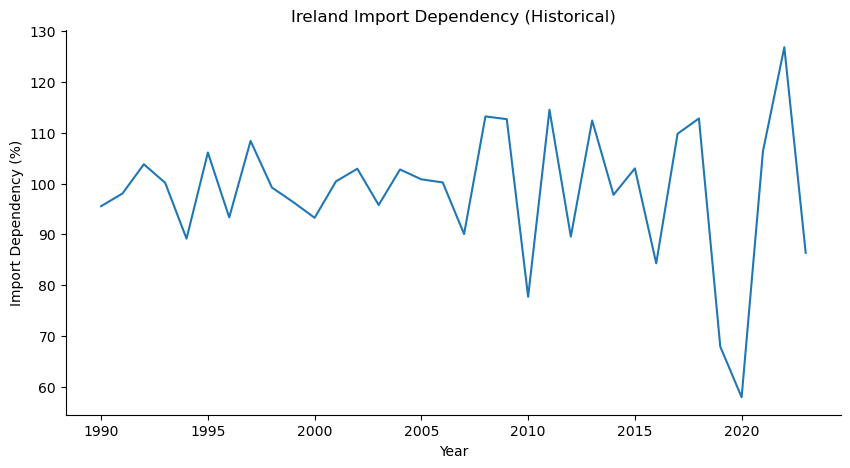

/Users/arjun/miniconda/miniconda3/envs/MSC_DA_CA2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


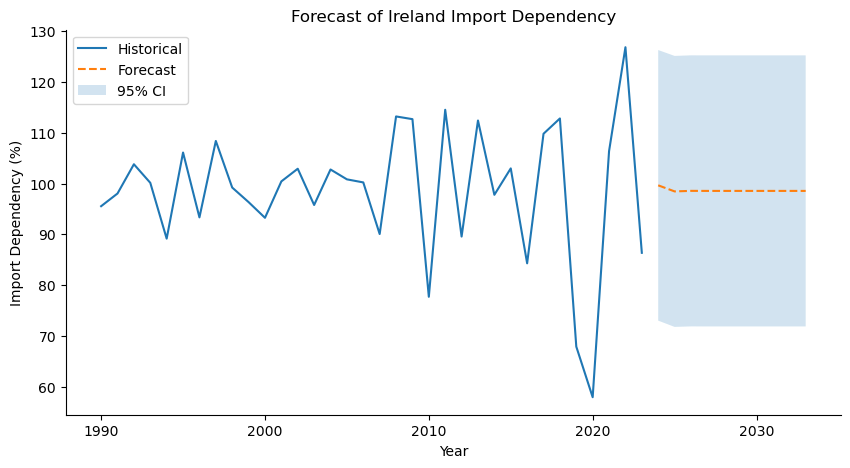

<Figure size 1000x500 with 0 Axes>

In [3]:
# One value per year for IE
ie = (df_import[df_import["geo"]=="IE"][["year","value"]]
      .dropna()
      .groupby("year", as_index=False)["value"].mean()
      .sort_values("year"))

# Build contiguous yearly series
years_full = np.arange(int(ie["year"].min()), int(ie["year"].max())+1)
hist = pd.Series(ie["value"].values, index=ie["year"].astype(int)).reindex(years_full).astype(float)
hist = hist.interpolate(limit_direction="both")
ts = hist.copy()
ts.index = pd.PeriodIndex(ts.index, freq="Y")

# Plot historical
plt.plot(ts.index.year, ts.values)
plt.title("Ireland Import Dependency (Historical)")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("forecast_ie_historical")

# ARIMA(1,1,1) → 10-year forecast
fit = ARIMA(ts, order=(1,1,1)).fit()
fc = fit.get_forecast(steps=10)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

df_forecast = pd.DataFrame({
    "year": fc_mean.index.year,
    "forecast": fc_mean.values,
    "lower": fc_ci.iloc[:,0].values,
    "upper": fc_ci.iloc[:,1].values
})

# Plot forecast
plt.plot(ts.index.year, ts.values, label="Historical")
plt.plot(df_forecast["year"], df_forecast["forecast"], "--", label="Forecast")
plt.fill_between(df_forecast["year"], df_forecast["lower"], df_forecast["upper"], alpha=0.2, label="95% CI")
plt.title("Forecast of Ireland Import Dependency")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
plt.legend()
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("forecast_ie_arima")

# Save for dashboard
df_forecast.to_csv(PROCESSED/"forecast_ie.csv", index=False)


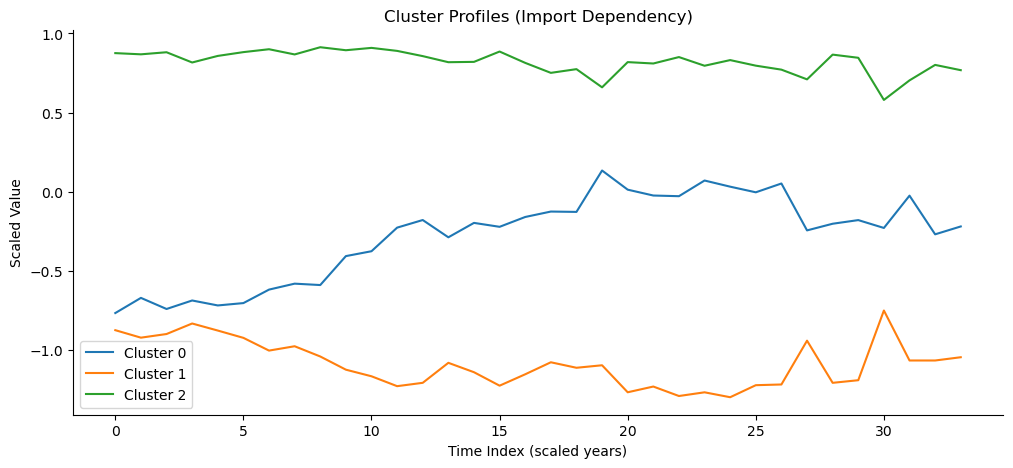

<Figure size 1000x500 with 0 Axes>

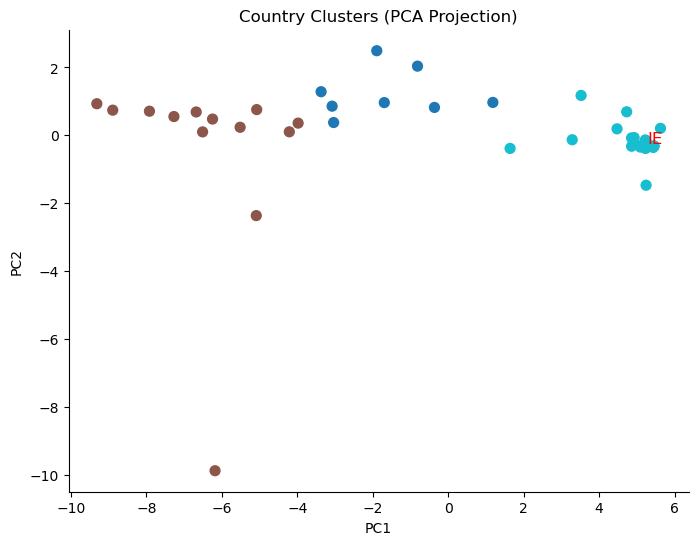

<Figure size 1000x500 with 0 Axes>

In [4]:
# Countries × Years matrix
pivot = df_import.pivot_table(index="geo", columns="year", values="value")

# Keep informative years/countries
pivot = pivot.loc[:, pivot.count() >= 15]   # years with ≥15 countries
pivot = pivot[pivot.count(axis=1) >= 10]    # countries with ≥10 years

# Impute: row mean then column mean, drop any remaining NA
pivot = pivot.apply(lambda r: r.fillna(r.mean()), axis=1)
pivot = pivot.fillna(pivot.mean())
pivot = pivot.dropna(axis=0).dropna(axis=1)

# Scale + KMeans
X = StandardScaler().fit_transform(pivot)
kmeans = KMeans(n_clusters=3, random_state=42)
pivot["cluster"] = kmeans.fit_predict(X)

# Centroid profiles
centroids = kmeans.cluster_centers_
plt.figure(figsize=(12,5))
for i, c in enumerate(centroids):
    plt.plot(c, label=f"Cluster {i}")
plt.title("Cluster Profiles (Import Dependency)")
plt.xlabel("Time Index (scaled years)"); plt.ylabel("Scaled Value")
plt.legend()
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("clusters_centroid_profiles")

# PCA scatter (label IE)
X_pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=pivot["cluster"], cmap="tab10", s=50)
for i, geo in enumerate(pivot.index):
    if geo == "IE":
        plt.text(X_pca[i,0], X_pca[i,1], "IE", fontsize=12, color="red")
plt.title("Country Clusters (PCA Projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False); plt.show()
save_fig("clusters_pca_scatter")

# Save clusters for dashboard
pivot.reset_index()[["geo","cluster"]].to_csv(PROCESSED/"clusters.csv", index=False)
